In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def lng_lat_to_pixels(lng, lat):
    lng_rad = lng * np.pi / 180
    lat_rad = lat * np.pi / 180
    x = (256/(2*np.pi))*(lng_rad + np.pi)
    y = (256/(2*np.pi))*(np.log(np.tan(np.pi/4 + lat_rad/2)))
    return (x, y)

In [3]:
def airbnb_athens_map(data: pd.DataFrame):
    
    data = data.copy()

    # restrict to the significant features 
    data = data[["neighbourhood_cleansed", "longitude", "latitude", "price"]]
    
    # convert object dtype into float
    data["price"] = [float(x[1:].replace(",", "")) if "," in x else float(x[1:]) for x in data["price"]]
    
    neighbourhoods = data.groupby("neighbourhood_cleansed")

    mean_scores = {}
    for name, group in neighbourhoods:
        mean_scores[name] = round(group["price"].mean(), 3)

    sorted_mean_scores = sorted(mean_scores.items(), key=lambda kv: kv[1])

    group_a = [sorted_mean_scores[i][0] for i in range(0, int(len(sorted_mean_scores)/4))]
    group_b = [sorted_mean_scores[i][0] for i in range(int(len(sorted_mean_scores)/4), int(len(sorted_mean_scores)/2))]
    group_c = [sorted_mean_scores[i][0] for i in range(int(len(sorted_mean_scores)/2), int(3*len(sorted_mean_scores)/4))]
    group_d = [sorted_mean_scores[i][0] for i in range(int(3*len(sorted_mean_scores)/4), len(sorted_mean_scores))]

    groups = []
    for idx in range(len(data)):
        if data["neighbourhood_cleansed"].iloc[idx] in group_a:
            groups.append("Group A")
        elif data["neighbourhood_cleansed"].iloc[idx] in group_b:
            groups.append("Group B")
        elif data["neighbourhood_cleansed"].iloc[idx] in group_c:
            groups.append("Group C")
        elif data["neighbourhood_cleansed"].iloc[idx] in group_d: 
            groups.append("Group D")
    data["neighbourhood_groups"] = groups
    
    data["price"] = (data["price"]-data["price"].min())/(data["price"].max()-data["price"].min())
    
    neighbourhood_category = data['neighbourhood_groups'].sort_values().astype('category')
    data['neighbourhood_groups_code'] = neighbourhood_category.cat.codes
    
    # convert geographical longitude and latitude into pixels
    data["longitude"], data["latitude"] = lng_lat_to_pixels(data["longitude"], data["latitude"])
    
    plt.figure(figsize=(18, 17))
    plt.axis('equal')
    plt.xlim(144.84, 144.911)
    plt.ylim(29.19, 29.28)
    plt.axis('off')
    plt.gca().set_facecolor('white')

    scatter = plt.scatter(
        x=data['longitude'], 
        y=data['latitude'], 
        s=data["price"]*2000,
        c=data['neighbourhood_groups_code'],
        alpha=0.6,
        edgecolors='k',
        label=data['neighbourhood_groups'],
        cmap='Spectral_r'
    )

    handles, labels = scatter.legend_elements(prop="colors", num=len(neighbourhood_category.cat.categories), 
                                              size=10, mec='k', alpha=0.6)
    labels = neighbourhood_category.cat.categories
    plt.legend(handles, labels, loc="best")

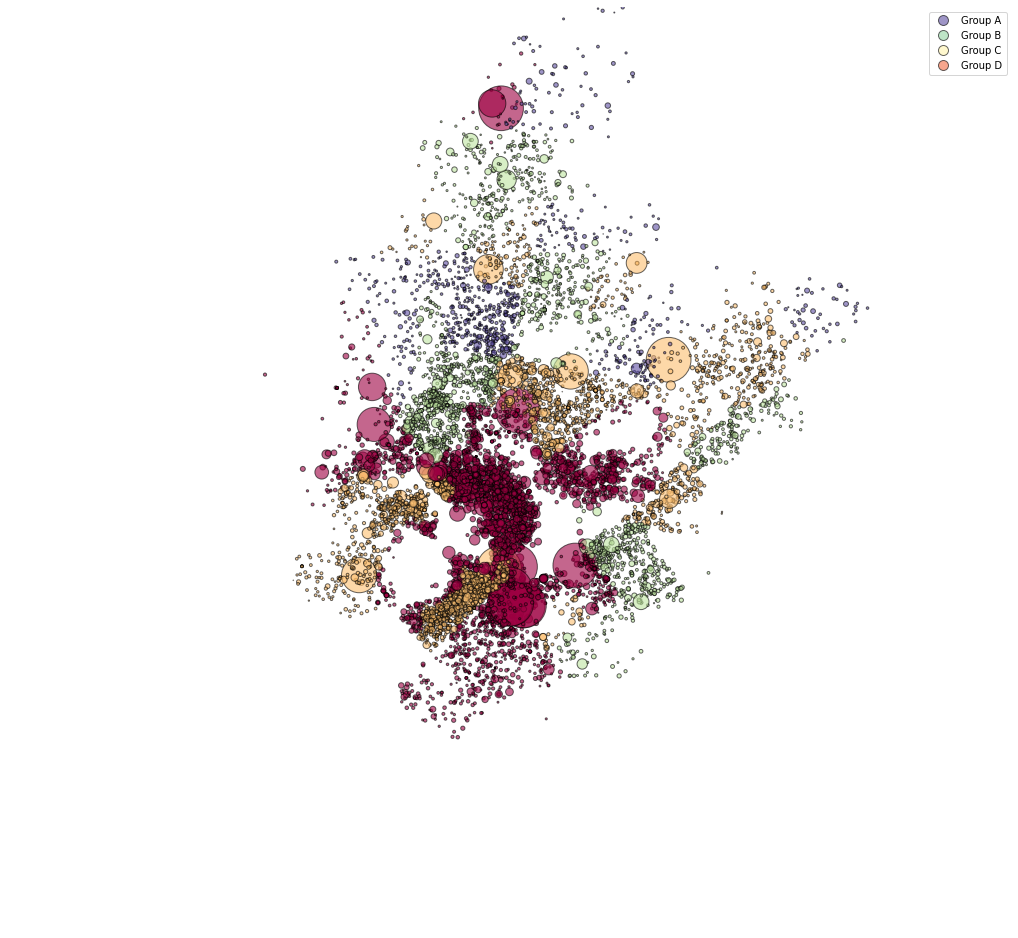

In [4]:
listings = pd.read_csv("data/listings.csv")
airbnb_athens_map(listings)